In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

Exercise 10.

In [2]:
import tensorflow_datasets as tfds

dataset, info = tfds.load('DeepWeeds', as_supervised=True, with_info=True)

In [3]:
info.splits['train']

<SplitInfo num_examples=17509, num_shards=4>

In [4]:
class_names = info.features['label'].names
num_classes = info.features['label'].num_classes
dataset_size = info.splits['train'].num_examples
print('class names:', class_names)
print('num_classes:', num_classes)
print('dataset_size:', dataset_size)

class names: ['Chinee apple', 'Lantana', 'Parkinsonia', 'Parthenium', 'Prickly acacia', 'Rubber vine', 'Siam weed', 'Snake weed', 'Negative']
num_classes: 9
dataset_size: 17509


In [5]:
test_set_raw, valid_set_raw, train_set_raw = tfds.load(
    'DeepWeeds', 
    split=['train[:10%]', 'train[10%:25%]', 'train[25%:]'],
    as_supervised=True)

In [6]:
len(train_set_raw), len(valid_set_raw), len(test_set_raw)

(13132, 2626, 1751)

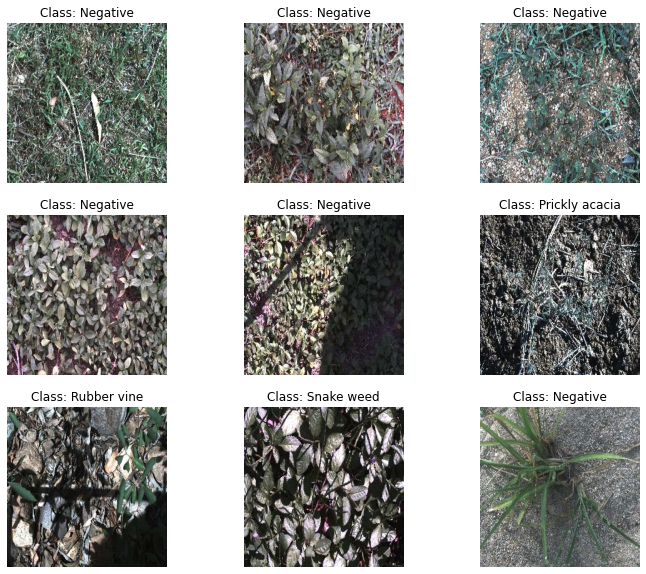

In [7]:
plt.figure(figsize=(12, 10))
index = 0
for image, label in train_set_raw.take(9):
    index += 1
    plt.subplot(3, 3, index)
    plt.imshow(image)
    plt.title("Class: {}".format(class_names[label]))
    plt.axis("off")

plt.show()

In [8]:
def central_crop(image):
    shape = tf.shape(image)
    min_dim = tf.reduce_min([shape[0], shape[1]])
    top_crop = (shape[0] - min_dim) // 4
    bottom_crop = shape[0] - top_crop
    left_crop = (shape[1] - min_dim) // 4
    right_crop = shape[1] - left_crop
    return image[top_crop:bottom_crop, left_crop:right_crop]

def random_crop(image):
    shape = tf.shape(image)
    min_dim = tf.reduce_min([shape[0], shape[1]]) * 90 // 100
    return tf.image.random_crop(image, [min_dim, min_dim, 3])

def preprocess(image, label, randomize=False):
    if randomize:
        cropped_image = random_crop(image)
        cropped_image = tf.image.random_flip_left_right(cropped_image)
    else:
        cropped_image = central_crop(image)
    resized_image = tf.image.resize(cropped_image, [224, 224])
    final_image = keras.applications.xception.preprocess_input(resized_image)
    return final_image, label

In [9]:
from functools import partial

batch_size = 32
train_set = train_set_raw.shuffle(1000)
train_set = train_set.map(partial(preprocess, randomize=True)).batch(batch_size).prefetch(1)
valid_set = valid_set_raw.map(preprocess).batch(batch_size).prefetch(1)
test_set = test_set_raw.map(preprocess).batch(batch_size).prefetch(1)

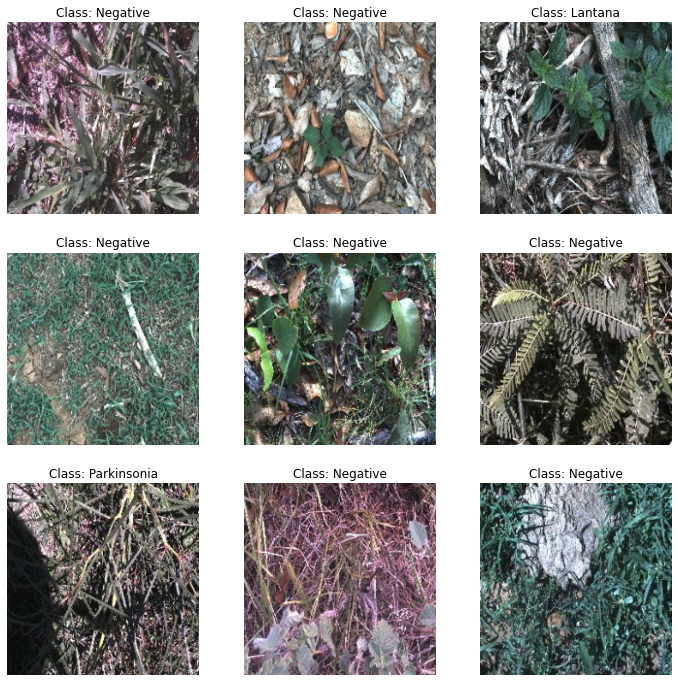

In [10]:
plt.figure(figsize=(12, 12))
for x_batch, y_batch in train_set.take(1):
    for index in range(9):
        plt.subplot(3, 3, index + 1)
        plt.imshow(x_batch[index] / 2 + 0.5)
        plt.title(f'Class: {class_names[y_batch[index]]}')
        plt.axis('off')

plt.show()

In [11]:
base_model = keras.applications.xception.Xception(weights='imagenet', 
                                                  include_top=False)
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
output = keras.layers.Dense(num_classes, activation='softmax')(avg)
model = keras.models.Model(inputs=base_model.input, outputs=output)

In [12]:
for layer in base_model.layers:
    layer.trainable = False

optimizer = keras.optimizers.SGD(learning_rate=0.2, momentum=0.9, decay=0.1)
model.compile(loss='sparse_categorical_crossentropy', 
              optimizer=optimizer, 
              metrics=['acc'])

history = model.fit(train_set, 
                    validation_data=valid_set, 
                    epochs=5)

Epoch 1/5
411/411 [==============================] - 140s 330ms/step - loss: 0.9910 - acc: 0.6693 - val_loss: 0.9011 - val_acc: 0.6820
Epoch 2/5
411/411 [==============================] - 93s 226ms/step - loss: 0.8141 - acc: 0.7183 - val_loss: 0.8641 - val_acc: 0.6931
Epoch 3/5
411/411 [==============================] - 87s 212ms/step - loss: 0.7947 - acc: 0.7230 - val_loss: 0.8510 - val_acc: 0.6976
Epoch 4/5
411/411 [==============================] - 87s 212ms/step - loss: 0.7921 - acc: 0.7211 - val_loss: 0.8454 - val_acc: 0.6976
Epoch 5/5
411/411 [==============================] - 88s 213ms/step - loss: 0.7737 - acc: 0.7318 - val_loss: 0.8352 - val_acc: 0.7034
